In [ ]:
!pip install pandas
!pip install numpy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('all_data.csv', names =['label', 'headline'], encoding='latin-1')

In [ ]:
!pip install pytorch-transformers
!pip install transformers

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip install keras

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip install sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip install matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Quadro P6000'

In [ ]:
sentences = df.headline.values

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

In [ ]:
df['label'] =df['label'].astype('category').cat.codes

In [ ]:
labels = df.label.values

In [ ]:
print(set(labels))

{0, 1, 2}


In [ ]:
df.label.unique()

array([1, 0, 2], dtype=int8)

In [ ]:
sentences[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing . [SEP] [CLS]'

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁according', '▁to', '▁', 'gran', '▁', ',', '▁the', '▁company', '▁has', '▁no', '▁plans', '▁to', '▁move', '▁all', '▁production', '▁to', '▁', 'rus', 'sia', '▁', ',', '▁although', '▁that', '▁is', '▁where', '▁the', '▁company', '▁is', '▁growing', '▁', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
MAX_LEN = 128

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs, dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    #print(b_labels)
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
#   # Validation

#   # Put model in evaluation mode to evaluate loss on the validation set
#   model.eval()

#   # Tracking variables 
#   eval_loss, eval_accuracy = 0, 0
#   nb_eval_steps, nb_eval_examples = 0, 0

#   # Evaluate data for one epoch
#   for batch in validation_dataloader:
#     # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
#     # Unpack the inputs from our dataloader
#     b_input_ids, b_input_mask, b_labels = batch
#     # Telling the model not to compute or store gradients, saving memory and speeding up validation
#     with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
#       logits = output[0]
    
#     # Move logits and labels to CPU
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
#     eval_accuracy += tmp_eval_accuracy
#     nb_eval_steps += 1

#   print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  50%|█████     | 1/2 [01:00<01:00, 60.37s/it]

Train loss: 0.839116922167481


Epoch: 100%|██████████| 2/2 [02:00<00:00, 60.20s/it]

Train loss: 0.42247652250235196


In [ ]:
directory_path = ""

In [ ]:
torch.save(model.state_dict(), directory_path+'/model_with_retraining.ckpt')


In [ ]:
# torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_predict = []
    y_true_ = []
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()
    
      y_predict.append(prediction)
      y_true_.append(b_labels)

In [ ]:
print('Test Accuracy of the model on vla data is: {} %'.format(100 * correct / total))


Test Accuracy of the model on vla data is: 84.02061855670104 %


In [ ]:
y_pred = [item for sublist in y_predict for item in sublist]
y_true = [item for sublist in y_true_ for item in sublist]

In [ ]:
y_pred = [x.cpu().numpy() for x in y_pred]
y_true = [x.cpu().numpy() for x in y_true]

In [ ]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.76      0.87      0.81       116
     neutral       0.84      0.93      0.88       580
    positive       0.91      0.63      0.74       274

    accuracy                           0.84       970
   macro avg       0.84      0.81      0.81       970
weighted avg       0.85      0.84      0.83       970



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[101,  10,   5],
       [ 27, 542,  11],
       [  5,  97, 172]])

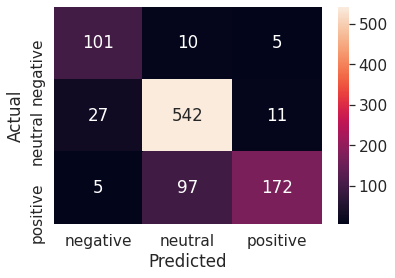

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, target_names, target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='d') # font size

plt.show()